In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join, vstack
import Euclid
from scipy.stats import wasserstein_distance
from scipy.signal import deconvolve
from scipy.fft import fft, ifft
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

plt.style.use('seaborn')
plt.style.use('seaborn-notebook')

In [2]:
nnpz = Table.read('/home/aalvarez/Work/Data/PV/Prod/lsst/75769/NnpzDes/output_file.fits', hdu=1)
len(nnpz)
mask = nnpz['FLAGS'] == 0
print(np.sum(mask), len(mask))
nnpz = nnpz[mask]

84071 101412


In [3]:
pdz_bins = Table.read('/home/aalvarez/Work/Data/PV/Prod/lsst/75769/NnpzDes/output_file.fits', hdu=2)
pdz_bins = pdz_bins['BINS_PDF']

In [4]:
phosphoros = Table.read('/home/aalvarez/Work/Data/PV/Calib/des_phosphoros.fits', hdu=1)
phosphoros.rename_column('ID', 'OBJECT_ID')
len(phosphoros)

101412

In [5]:
cross = join(nnpz, phosphoros, 'OBJECT_ID', table_names=['nnpz', 'pho'])
len(cross)

84071

In [6]:
all_idx = np.arange(len(cross))
np.random.shuffle(all_idx)
cut = int(len(cross) * 0.6)
training_idx = all_idx[:cut]
testing_idx = all_idx[cut:]

In [7]:
mean_kernel = np.zeros_like(pdz_bins)
count = 0
for row in tqdm(cross[training_idx]):
    in_pdz = fft(row['REDSHIFT_PDF'])
    out_pdz = fft(row['Z-1D-PDF'])
    k = np.roll(np.real(ifft(out_pdz/in_pdz)), 300)
    k /= np.sum(k)
    if all(np.isfinite(k)):
        mean_kernel += k
        count += 1
mean_kernel /= count

  0%|          | 0/50442 [00:00<?, ?it/s]

In [8]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [mean_kernel.max(), np.average(pdz_bins, weights=mean_kernel), 0.2]

coeff, var_matrix = curve_fit(gauss, pdz_bins, mean_kernel, p0=p0)

In [9]:
p0, coeff

([0.05823946, 3.0499735, 0.2], array([0.05106173, 3.00787532, 0.06499222]))

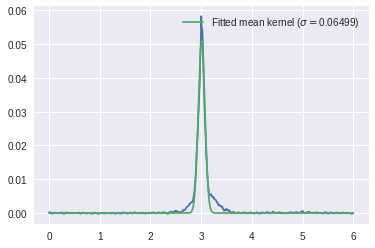

In [10]:
plt.figure()
plt.plot(pdz_bins, mean_kernel)
plt.plot(pdz_bins, gauss(pdz_bins, *coeff), label=f'Fitted mean kernel ($\\sigma = ${coeff[2]:.4})')
plt.legend()
plt.savefig('/home/aalvarez/Downloads/des_mean_kernel.png')

In [11]:
np.save('testing_idx.npy', testing_idx)